
_Written by Célia Desgrange, 2023-09-06

If problem should look into the script plot_snr_maps as I divided this script into two scripts, including this one.

In [179]:
import glob
import numpy as np
import time, os

from astropy.convolution import (convolve_fft, convolve, Gaussian2DKernel)

#import vip_hci as vip
#from astropy.io import fits
#import cv2 

from import_functions_generic import * 
from import_functions_plotting import * 
#from image_manipulation import * 



In [180]:
plt.style.use('classic')  
mpl.rc('image', cmap='viridis')#, origin='lower')
#mpl.rc('text', usetex=True)
#mpl.rc(mathtext.fontset = 'stix')


rcParams.update({'font.size': 14,  'axes.labelsize' : 14, 'legend.fontsize' : 12,
"font.family": "serif", 'text.usetex' : True, "font.serif": [], "font.sans-serif": [],
'legend.handlelength': 1.5, 'legend.borderaxespad' : 0.8, 'legend.columnspacing' : 1, 'legend.handletextpad' : 0.5})

rcParams['mathtext.fontset'] = 'stix'

In [181]:
L = time.localtime()
date = "{}-{}-{}".format(L[0],L[1],L[2],L[3],L[4],L[5])

saving_dir = 'figs/fig_v{}/'.format(date)
os.makedirs(saving_dir,exist_ok=True)

# Main parameters

In [182]:
# cmaps
cmap_dark_red =  seaborn.blend_palette([[1,0,0],'crimson','firebrick','darkred',[0.3,0,0]], as_cmap=True)
cmap_red = seaborn.blend_palette(['white',[1,0.95,0],'orange', 'red'], as_cmap=True)
cmap_orange = seaborn.blend_palette(['white',[1,0.95,0],'gold'], as_cmap=True)
cmap_pinkish = seaborn.blend_palette(['white',[1,0.5,1],'purple', 'blue'], as_cmap=True)
cmap_pink = seaborn.blend_palette(['white',[1,0.4,1],[0.8,0,0.7],[0.75,0,0.7]], as_cmap=True)
cmap_blue = seaborn.blend_palette(['white',[0.5,0.9,1], [0,0.5,1],  [0,0,1]], as_cmap=True)
cmap_blue_light = seaborn.blend_palette(['white',[0.5,0.9,1], [0,0.5,1]], as_cmap=True)
cmap_white = seaborn.blend_palette(['white', 'ivory'], as_cmap=True)
cmap = cmap_white

list_rainbow = ['blue','skyblue','hotpink', 'purple','gold','red','orange']
colors_rainbow = seaborn.blend_palette(list_rainbow,7)
display(colors_rainbow)

MARKERS_IFS = ['<','>','<','>','D','D','o']
COLORS_IFS = colors_rainbow

[(0.0, 0.0, 1.0),
 (0.5231833910034602, 0.7983391003460208, 0.9224913494809688),
 (1.0, 0.4117647058823529, 0.7058823529411765),
 (0.5078200692041522, 0.00991926182237601, 0.4960553633217993),
 (1.0, 0.8431372549019608, 0.0),
 (1.0, 0.007612456747405272, 0.0),
 (1.0, 0.6470588235294118, 0.0)]

In [183]:
# Image - observation
pixel_scale=0.01225 # pixel scale in arcsec/px 
platescale = pixel_scale*1e3
scalebar_pix, scalebar_leg = 1000, '1"'
scalebar_sep, scalebar_pad = 5, 0.1
nx = 624 # number of pixels of your image in X
ny = 624 # number of pixels of your image in Y

# Save file .fits
writeto = False # save .fits file

# Figure
add_colorbar=0
figsize_rectange, figsize_square  = (4,3), (3,3)
figsize = np.where(add_colorbar, figsize_rectange, figsize_square)
left, right = 0.01, float(np.where(add_colorbar, 0.78, 0.99))
top, bottom = float(np.where(add_colorbar, 0.95, 0.99)), float(np.where(add_colorbar, 0.05, 0.01))
im_crop = 250
save_png = 0    # save .png file
cbar_xdeb = 0.83
scalebar_pix, scalebar_leg = 100, '0.1"'

text_xfrac, text_yfrac = 0.03, 0.84
filt='H'

# Contours
alpha=0.6

# System
dstar = 113.27
scalebar_au = '{:.0f}\,au'.format(dstar*scalebar_pix*1e-3)


In [165]:
# Initialize the path to the wished data 
# -> supposed to be changed accordingly to the data/computer used
infolder = '/Users/desgranc/Documents/work/projects/HD120326/data/'
folder_prereduced = 'prereduced/convert/'
folder_reduced = 'reduced/'
dF       = pd.read_csv(infolder + 'list_obs.txt',sep='\t')
dF

,target,epoch,instrument,polar,filter,quality,"seeing ("")",tau0 (ms),delta pa (deg),PI,DIT (s),Nb frames,Total exposure (min)
0,HD_120326,2016-04-05,IRDIS,no,H23,good,1.1,3.5,37,Bonnefoy & Ménard,32.0,128.0,68.0
1,HD_120326,2016-06-03,IRDIS,no,H23,good,0.71,3.1,22,Hinkley & Matthews,32.0,80.0,43.0
2,HD_120326,2016-06-13,IRDIS,no,J23,to check,to check,to check,NaN,GTO,NaN,NaN,NaN
3,HD_120326,2018-06-01,IRDIS,yes,BB_H,very good,0.45,4.2,Boccaletti,NaN,NaN,NaN,NaN
4,HD_120326,2019-06-26,IRDIS,no,BB_H,very bad,1.84,2.4,36,Bonnefoy & Ménard,NaN,NaN,NaN
5,HD_120326,2019-07-09,IRDIS,no,BB_H,very good,0.54,3.1,58,Bonnefoy & Ménard,32.0,224.0,119.0
6,HD_120326,2016-04-05,IFS,no,YJ,good,1.1,3.5,37,Bonnefoy & Ménard,64.0,64.0,68.0
7,HD_120326,2016-06-03,IFS,no,YJ,good,0.71,3.1,22,Hinkley & Matthews,64.0,40.0,43.0
8,HD_120326,2019-06-26,IFS,no,YJ,very bad,1.84,2.4,36,Bonnefoy & Ménard,NaN,NaN,NaN
9,HD_120326,2019-07-09,IFS,no,YJ,very good,0.54,3.1,58,Bonnefoy & Ménard,64.0,112.0,119.0


# POLARIMETRY

## I. Load an observation

In [166]:
idx, idx_pcs, before_or_after,sorting = 3, 10, 'after', 'softsorting'
epoch = str(dF['epoch'].iloc[idx])
filt =  str(dF['filter'].iloc[idx])
print(filt)
if filt == 'BB_H': filt = 'H'
if filt == 'H23': filt = 'H2'
algo = 'IRDAP'
print('Load the epoch: {}'.format(epoch))
path_im_reduced = infolder + folder_reduced + algo + '/*{}*{}*{}_cube_im_pca.fits'.format(epoch,before_or_after,sorting)
obs_polar = str(dF['polar'].iloc[idx])
if obs_polar == 'yes': 
    print('(!) polarized light')
    path_im_reduced = infolder + folder_reduced + algo + '/{}/reduced_pdi/star_pol*/*subtr*flux*2.fits'.format(epoch)

print('It corresponds do the path:\n{}'.format(path_im_reduced))
print('\nFiles found:')
flist = glob(path_im_reduced)
flist = np.sort(flist)
for f in flist: print('-',f)
    

im_reduced_polar_Ipol = fits.getdata(flist[0])
im_reduced_polar_QPHI = fits.getdata(flist[1])
im_reduced_polar_UPHI = fits.getdata(flist[2])

BB_H
Load the epoch: 2018-06-01
(!) polarized light
It corresponds do the path:
/Users/desgranc/Documents/work/projects/HD120326/data/reduced/IRDAP/2018-06-01/reduced_pdi/star_pol*/*subtr*flux*2.fits

Files found:
- /Users/desgranc/Documents/work/projects/HD120326/data/reduced/IRDAP/2018-06-01/reduced_pdi/star_pol_subtr/HIP67497_2018-06-02_I_pol_star_pol_subtr_flux_jy_arcsec2.fits
- /Users/desgranc/Documents/work/projects/HD120326/data/reduced/IRDAP/2018-06-01/reduced_pdi/star_pol_subtr/HIP67497_2018-06-02_Q_phi_star_pol_subtr_flux_jy_arcsec2.fits
- /Users/desgranc/Documents/work/projects/HD120326/data/reduced/IRDAP/2018-06-01/reduced_pdi/star_pol_subtr/HIP67497_2018-06-02_U_phi_star_pol_subtr_flux_jy_arcsec2.fits


## II. Plot the observation in Jy/arcsec2 - without contours

In [167]:
from astropy.convolution import (convolve_fft, convolve, Gaussian2DKernel)
help(gauss2d)

Help on function gauss2d in module import_functions_generic:

gauss2d(x=0, y=0, mx=0, my=0, sx=2, sy=2)



In [168]:
kernel = generate_kernel(2)
im_model_conv =  convolve_fft(im_reduced_polar, kernel)

#plt.imshow(kernel,interpolation='nearest')
#plt.imshow(im_model_conv[im_crop_IRDAP:-im_crop_IRDAP,im_crop_IRDAP:-im_crop_IRDAP],interpolation='nearest', origin='lower')

### QPhi

Size of the image = 1024 and crop = 450 i.e. size of the image shown = 124
The file is saved here:
 figs/fig_v2023-9-12/im_model_irdap_2018-06-01_Qphi_Jyarcsec2


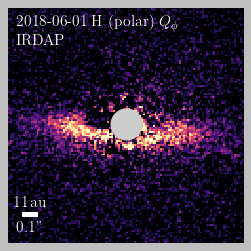

In [193]:
# Without colorbar

namesave = 'im_model_{}_{}_Qphi_Jyarcsec2'.format(algo.lower(), epoch)

im_model = im_reduced_polar_QPHI*1e6
#im_model = im_model_conv*1e6
im = np.copy(im_model)
im_crop_model = im_crop_IRDAP
im_crop = im_crop_model
n_final = len(im)-2*im_crop

print('Size of the image =', len(im), 'and crop =', im_crop, 
      'i.e. size of the image shown =',  n_final)

clab = 'contrast'
vmin, vmax = 0, 5

text = '{} {} (polar) $Q_\phi$\n{}'.format(epoch, filt, algo)

fig, ax = plot_fig(im=im, vmin=vmin, vmax=vmax, im_crop=im_crop, 
         scalebar_arcsec=scalebar_pix, scalebar_leg=scalebar_leg, 
         scalebar_label_top=0, scalebar_sep=scalebar_sep, scalebar_pad=scalebar_pad,
         platescale=platescale, figsize=figsize,
         add_colorbar=add_colorbar, clab=clab, cbar_xdeb=cbar_xdeb, add_text=1,
         text=text, text_xfrac=text_xfrac, text_yfrac=text_yfrac, color_text='white',
         right=right, left=left, top=top, bottom=bottom,
         saving_dir=saving_dir, save_png=save_png, namesave=namesave,
        give_fig_ax=False, return_fig_ax=True, do_tight_layout=0)


# Add IWA
h, w = n_final, n_final
r_IWA = 100
IWA_color = [0.8,0.8,0.8]
circle = Circle((h/2,w/2),r_IWA/platescale,ec=IWA_color,fc=IWA_color,ls='-',lw=1)
ax.add_patch(circle)

# Add scale bar au
ax.text(text_xfrac*0.8,0.155, scalebar_au, color='white', transform=ax.transAxes)

print('The file is saved here:\n', saving_dir+namesave)
plt.savefig(saving_dir+namesave+'.pdf')
if save_png: plt.savefig(saving_dir+namesave+'.png', dpi=200)
plt.show()

In [133]:
scalebar_pix

100

### Uphi -- without the color bar

Size of the image = 1024 and crop = 450 i.e. size of the image shown = 124
The file is saved here:
 figs/fig_v2023-9-12/im_model_irdap_2018-06-01_Uphi_Jyarcsec2


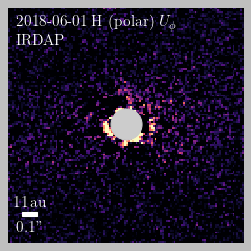

In [192]:
# Without colorbar

namesave = 'im_model_{}_{}_Uphi_Jyarcsec2'.format(algo.lower(), epoch)

im_model = im_reduced_polar_UPHI*1e6
#im_model = im_model_conv*1e6
im = np.copy(im_model)
im_crop_model = im_crop_IRDAP
im_crop = im_crop_model
n_final = len(im)-2*im_crop

print('Size of the image =', len(im), 'and crop =', im_crop, 
      'i.e. size of the image shown =',  n_final)

clab = 'contrast'
vmin, vmax = 0, 5

text = '{} {} (polar) $U_\phi$\n{}'.format(epoch, filt, algo)

fig, ax = plot_fig(im=im, vmin=vmin, vmax=vmax, im_crop=im_crop, 
         scalebar_arcsec=scalebar_pix, scalebar_leg=scalebar_leg, 
         scalebar_label_top=0, scalebar_sep=scalebar_sep, scalebar_pad=scalebar_pad,
         platescale=platescale, figsize=figsize,
         add_colorbar=add_colorbar, clab=clab, cbar_xdeb=cbar_xdeb, add_text=1,
         text=text, text_xfrac=text_xfrac, text_yfrac=text_yfrac, color_text='white',
         right=right, left=left, top=top, bottom=bottom,
         saving_dir=saving_dir, save_png=save_png, namesave=namesave,
        give_fig_ax=False, return_fig_ax=True, do_tight_layout=0)

# Add scale bar au
ax.text(text_xfrac*0.8,0.155, scalebar_au, color='white', transform=ax.transAxes)

# Add IWA
h, w = n_final, n_final
r_IWA = 100
IWA_color = [0.8,0.8,0.8]
circle = Circle((h/2,w/2),r_IWA/platescale,ec=IWA_color,fc=IWA_color,ls='-',lw=1)
ax.add_patch(circle)


print('The file is saved here:\n', saving_dir+namesave)
plt.savefig(saving_dir+namesave+'.pdf')
if save_png: plt.savefig(saving_dir+namesave+'.png', dpi=200)
plt.show()

## Uphi - with the color bar

Size of the image = 1024 and crop = 450 i.e. size of the image shown = 124
The file is saved here:
 figs/fig_v2023-9-12/im_model_irdap_2018-06-01_Uphi_Jyarcsec2_cbar


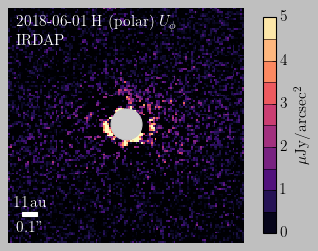

In [188]:
# With a colorbar
add_colorbar = 1
figsize_cbar = (4,3)
clab = r'$\mu$Jy/arcsec$^2$'

namesave = 'im_model_{}_{}_Uphi_Jyarcsec2_cbar'.format(algo.lower(), epoch)

im_model = im_reduced_polar_UPHI*1e6
#im_model = im_model_conv*1e6
im = np.copy(im_model)
im_crop_model = im_crop_IRDAP
im_crop = im_crop_model
n_final = len(im)-2*im_crop

print('Size of the image =', len(im), 'and crop =', im_crop, 
      'i.e. size of the image shown =',  n_final)

vmin, vmax = 0, 5
text = '{} {} (polar) $U_\phi$\n{}'.format(epoch, filt, algo)

fig, ax = plot_fig(im=im, vmin=vmin, vmax=vmax, im_crop=im_crop, 
         scalebar_arcsec=scalebar_pix, scalebar_leg=scalebar_leg, 
         scalebar_label_top=0, scalebar_sep=scalebar_sep, scalebar_pad=scalebar_pad,
         platescale=platescale, figsize=figsize_cbar,
         add_colorbar=add_colorbar, clab=clab, cbar_edges_nb=11,
        cbar_xdeb=0.81, cbar_ydeb=0.05, cbar_xwidth=0.04, cbar_ywidth=0.9,
          add_text=1, text=text, text_xfrac=text_xfrac, text_yfrac=text_yfrac, color_text='white',
         right=0.75, left=left, top=top, bottom=bottom,
         saving_dir=saving_dir, save_png=save_png, namesave=namesave,
        give_fig_ax=False, return_fig_ax=True, do_tight_layout=0)

# Add scale bar au
ax.text(text_xfrac*0.8,0.155, scalebar_au, color='white', transform=ax.transAxes)

# Add IWA
h, w = n_final, n_final
r_IWA = 100
IWA_color = [0.8,0.8,0.8]
circle = Circle((h/2,w/2),r_IWA/platescale,ec=IWA_color,fc=IWA_color,ls='-',lw=1)
ax.add_patch(circle)


print('The file is saved here:\n', saving_dir+namesave)
plt.savefig(saving_dir+namesave+'.pdf')
if save_png: plt.savefig(saving_dir+namesave+'.png', dpi=200)
plt.show()

### Ipol

Size of the image = 1024 and crop = 450 i.e. size of the image shown = 124
The file is saved here:
 figs/fig_v2023-9-12/im_model_irdap_2018-06-01_I_Jyarcsec2


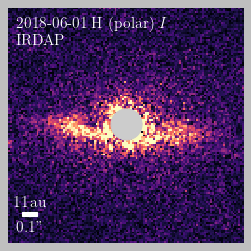

In [189]:
# Without colorbar
namesave = 'im_model_{}_{}_I_Jyarcsec2'.format(algo.lower(), epoch)

im_model = im_reduced_polar_Ipol*1e6
#im_model = im_model_conv*1e6
im = np.copy(im_model)
im_crop_model = im_crop_IRDAP
im_crop = im_crop_model
n_final = len(im)-2*im_crop

print('Size of the image =', len(im), 'and crop =', im_crop, 
      'i.e. size of the image shown =',  n_final)

add_colorbar=0
vmin, vmax = 0, 5

text = '{} {} (polar) $I$\n{}'.format(epoch, filt, algo)

fig, ax = plot_fig(im=im, vmin=vmin, vmax=vmax, im_crop=im_crop, 
         scalebar_arcsec=scalebar_pix, scalebar_leg=scalebar_leg, 
         scalebar_label_top=0, scalebar_sep=scalebar_sep, scalebar_pad=scalebar_pad,
         platescale=platescale, figsize=figsize,
         add_colorbar=add_colorbar, clab=clab, cbar_xdeb=cbar_xdeb, add_text=1,
         text=text, text_xfrac=text_xfrac, text_yfrac=text_yfrac, color_text='white',
         right=right, left=left, top=top, bottom=bottom,
         saving_dir=saving_dir, save_png=save_png, namesave=namesave,
        give_fig_ax=False, return_fig_ax=True, do_tight_layout=0)

# Add scale bar au
ax.text(text_xfrac*0.8,0.155, scalebar_au, color='white', transform=ax.transAxes)

# Add IWA
h, w = n_final, n_final
r_IWA = 100
IWA_color = [0.8,0.8,0.8]
circle = Circle((h/2,w/2),r_IWA/platescale,ec=IWA_color,fc=IWA_color,ls='-',lw=1)
ax.add_patch(circle)


print('The file is saved here:\n', saving_dir+namesave)
plt.savefig(saving_dir+namesave+'.pdf')
if save_png: plt.savefig(saving_dir+namesave+'.png', dpi=200)
plt.show()

In [184]:


def plot_fig(im, clab='', vmin=None, vmax=None, text='None', text_xfrac=0.03, text_yfrac=0.9, color_text='white', add_text=0,
        show_axis_ticks='off', im_crop=0, platescale_use_binning_factor=0, binning_factor=None, flux_use_binning_factor=0,
        scalebar_arcsec=0.1, scalebar_leg='0.1"', scalebar_loc=3, platescale=12.25, 
        scalebar_color='white', scalebar_pad=0.4, scalebar_sep=2, scalebar_borderpad=0.5, scalebar_label_top=True,
        add_colorbar=1, cbar_xdeb=0.82, cbar_ydeb=0.1, cbar_xwidth=0.03, cbar_ywidth=0.8,
        cbar_edges_nb=None, cbar_bound=None,
        right=0.8, top=0.95, left=0.01, bottom=0.05, figsize=(5,4),
        interpolation='nearest', saving_dir='', namesave='test', save_png=0, cmap='magma',norm=None, do_tight_layout=1,
        return_fig_ax=False, give_fig_ax=False, fig=None, ax=None, show=1):

    if not give_fig_ax: 
        fig, ax = plt.subplots(1,1, figsize=figsize)
        fig.subplots_adjust(left=left, right=right, top=top, bottom=bottom)
    ax.axis(show_axis_ticks)

    if im_crop != 0: im = im[im_crop:-im_crop,im_crop:-im_crop]

    if vmin != None and vmax != None: im_plot = ax.imshow(im, vmin=vmin, vmax=vmax, origin='lower', interpolation=interpolation, cmap=cmap, norm=norm)
    elif vmax != None : im_plot = ax.imshow(im, vmax=vmax, origin='lower', interpolation=interpolation, cmap=cmap, norm=norm)
    elif vmin != None : im_plot = ax.imshow(im, vmin=vmin, origin='lower', interpolation=interpolation, cmap=cmap, norm=norm)
    else : im_plot = ax.imshow(im, origin='lower', interpolation=interpolation, cmap=cmap, norm=norm)

    # Add text
    if add_text:
        w,h = np.shape(im)
        ax.text(w*text_xfrac,h*text_yfrac,text,color=color_text)

    # Add scalebar
    if platescale_use_binning_factor: factor = binning_factor[i]
    else: factor = 1
    size = scalebar_arcsec/(platescale*factor)
    scalebar = AnchoredSizeBar(ax.transData, size, scalebar_leg, scalebar_loc, label_top=scalebar_label_top, pad=scalebar_pad,
                               sep=scalebar_sep, borderpad=scalebar_borderpad, frameon=False, size_vertical=2/factor, color=scalebar_color)#,fontproperties=fp)
    ax.add_artist(scalebar)

    # Add colorbar
    if add_colorbar:
        # Color bar
        cb_xdeb, cb_ydeb, cb_xwidth, cb_ywidth = cbar_xdeb, cbar_ydeb, cbar_xwidth, cbar_ywidth
        cb_ax = fig.add_axes([cb_xdeb, cb_ydeb, cb_xwidth, cb_ywidth])

        # Cbar edges
        if cbar_edges_nb != None: 
            cbar_labels = np.linspace(vmin,vmax,cbar_edges_nb)
            cbar_bound  = np.linspace(vmin,vmax,cbar_edges_nb)
    
        cbar = fig.colorbar(im_plot, cax=cb_ax, orientation='vertical', 
                            boundaries=cbar_bound, drawedges=True,
                            pad=0.8, shrink=0.05,fraction=0.01,aspect=50)#,width_fraction=0.001)
        cbar.set_label(clab)
        #cbar.set_ticklabels(cbar_labels)
            
        
    if do_tight_layout: plt.tight_layout()
        
    if return_fig_ax: return fig, ax
    else: 
        print('The file is saved here:\n', saving_dir+namesave)
        plt.savefig(saving_dir+namesave+'.pdf', dpi=300)
        if save_png: plt.savefig(saving_dir+namesave+'.png', dpi=200)
    if show: plt.show()
    return


